# Credit risk model.

## 1. Import modules

In [73]:

import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import statsmodels.formula.api as smf
from sklearn.metrics import accuracy_score, confusion_matrix
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt

# 2. Read the data and understand the data

In [12]:
#read the dataset
data = pd.read_csv("credit_risk_dataset.csv")
data.head()



,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [ ]:
#In this dataset, we do not have an ID to define each customer uniquely. Therefore, we can assume that each row is independent and we will not remove duplicates, as this can be useful information.

In [343]:
#info about the variables
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


<AxesSubplot:xlabel='loan_status', ylabel='count'>

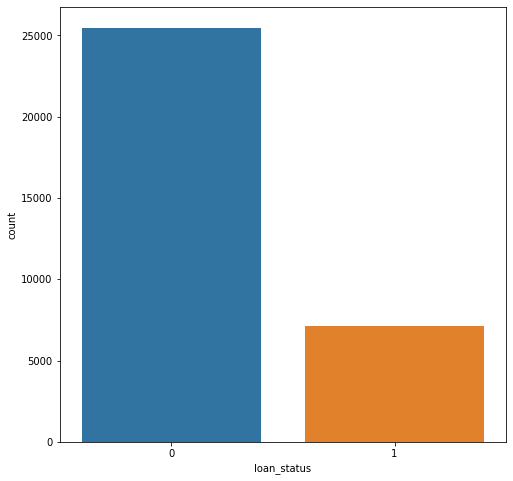

In [49]:

#Check the proportion of defaults
data.groupby(['loan_status']).size()/data.shape[0]
plt.figure(figsize=(8,8))
sns.countplot(x=data["loan_status"])


# 3. Data preparation

In [281]:
# Split the data into train and test sample. 
X = data.drop('loan_status', axis=1)
X.shape
y = data['loan_status']
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42)

In [345]:

X_train.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
count,26064.000000,2.606400e+04,25347.000000,26064.000000,23585.000000,26064.000000,26064.000000
mean,27.764695,6.617184e+04,4.787233,9601.073320,11.010116,0.170446,5.816720
std,6.392500,6.359933e+04,4.109243,6315.753396,3.228901,0.106991,4.054342
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000
25%,23.000000,3.900000e+04,2.000000,5000.000000,7.900000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.150000,4.000000
75%,30.000000,7.950000e+04,7.000000,12250.000000,13.470000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,22.480000,0.780000,30.000000


## 3.1 Dealing with NA's.

In [347]:
#First, we need to check the proportion of NA's 
def missing(df):
    return round(df.isnull().sum()/df.shape[0]*100,2)

missing(data)


person_age                    0.00
person_income                 0.00
person_home_ownership         0.00
person_emp_length             2.75
loan_intent                   0.00
loan_grade                    0.00
loan_amnt                     0.00
loan_int_rate                 9.56
loan_status                   0.00
loan_percent_income           0.00
cb_person_default_on_file     0.00
cb_person_cred_hist_length    0.00
dtype: float64

In [177]:

#We need to determine what we are going to do with the NA's. We should study whether actually finding an NA in one of the explanatory variables gives us information about whether the customer is more likely to be a defaulter.
data[data['loan_int_rate'].isnull()].describe()

# The mean of the dependent variable for the 3116 records where the variable loan_int_rate is null, it is 0.20 which is similar to the average default rate of the entire sample, concluding that we aren't excluding some relevant information for the detection of defaulters.

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,3116.000000,3.116000e+03,3048.000000,3116.000000,0.0,3116.000000,3116.000000,3116.000000
mean,27.922657,6.658905e+04,4.799213,9633.119384,NaN,0.206675,0.171088,5.955071
std,6.782386,6.275810e+04,4.028823,6377.661049,NaN,0.404985,0.105870,4.264216
min,20.000000,4.888000e+03,0.000000,500.000000,NaN,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,NaN,0.000000,0.090000,3.000000
50%,26.000000,5.564000e+04,4.000000,8000.000000,NaN,0.000000,0.150000,4.000000
75%,30.000000,8.000000e+04,7.000000,12000.000000,NaN,0.000000,0.230000,8.000000
max,123.000000,1.900000e+06,28.000000,35000.000000,NaN,1.000000,0.630000,30.000000


In [18]:
# Some models don't allow NA in the independent variables so we will need to input a value where we have a NA. Therefore, we are going to create two new variables and we are going to study the behaviour of both of them. The first one will be equal to the loan_int_rate and the null values will be replaced by the average of loan_int_rate and the second one will be identical but changing the null values for 0.
X_train.loan_int_rate.mean()
X_train['mean_loan_interest'] = np.where(
X_train['loan_int_rate'].isnull, 
X_train["loan_int_rate"].fillna(value=X_train["loan_int_rate"].mean()),   X_train['loan_int_rate'])
X_train['0_loan_interest'] = np.where(
X_train['loan_int_rate'].isnull, 
X_train["loan_int_rate"].fillna(value=0),   X_train['loan_int_rate'])

/mnt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/mnt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# 4. Univariate analysis
## We are going to estimate the predictive power of the variables individually

In [14]:
#IV and WOE of the variables

def iv_woe(data, target, bins=10, show_woe=False):
    
    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    
    #Extract Column Names
    cols = data.columns
    
    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})

        
        # Calculate the number of events in each group (bin)
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        
        # Calculate % of events in each group.
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()

        # Calculate the non events in each group.
        d['Non-Events'] = d['N'] - d['Events']
        # Calculate % of non events in each group.
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()

        # Calculate WOE by taking natural log of division of % of non-events and % of events
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

        #Show WOE Table
        if show_woe == True:
            print(d)
    return newDF, woeDF

In [19]:
new_data = pd.concat([X_train,y_train],axis=1)
new_data.head()
iv_woe(new_data, 'loan_status', bins=10, show_woe=False)

Information value of person_age is 0.00948
Information value of person_income is 0.464682
Information value of person_home_ownership is 0.378239
Information value of person_emp_length is 0.057632
Information value of loan_intent is 0.089566
Information value of loan_grade is 0.868905
Information value of loan_amnt is 0.092895
Information value of loan_int_rate is 0.72067
Information value of loan_percent_income is 0.90951
Information value of cb_person_default_on_file is 0.160981
Information value of cb_person_cred_hist_length is 0.003007
Information value of mean_loan_interest is 0.626998
Information value of 0_loan_interest is 0.613674


(                     Variable        IV
 0                  person_age  0.009480
 0               person_income  0.464682
 0       person_home_ownership  0.378239
 0           person_emp_length  0.057632
 0                 loan_intent  0.089566
 0                  loan_grade  0.868905
 0                   loan_amnt  0.092895
 0               loan_int_rate  0.720670
 0         loan_percent_income  0.909510
 0   cb_person_default_on_file  0.160981
 0  cb_person_cred_hist_length  0.003007
 0          mean_loan_interest  0.626998
 0             0_loan_interest  0.613674,
            Variable          Cutoff     N  Events  % of Events  Non-Events  \
 0        person_age  (19.999, 22.0]  3880     993     0.175349        2887   
 1        person_age    (22.0, 23.0]  3124     674     0.119018        2450   
 2        person_age    (23.0, 24.0]  2829     600     0.105951        2229   
 3        person_age    (24.0, 25.0]  2415     528     0.093237        1887   
 4        person_age    (25.0,

# 5. Multivariate model

## It seems that the loan_int_rate has a higher IV than the one we have created, so we will use this variable for the final model. Some variables are not accurate in describing customer behaviour. We will also exclude from the final model all variables with an IV lower than 0.2.

# 5.1. Logistic regression




In [20]:
#First we need to check the correlation between the numerical variables of the model. In the logistic regression we can't 

new_data2= new_data.drop(['person_age','person_emp_length','loan_intent','loan_int_rate','loan_status','loan_amnt','cb_person_cred_hist_length'], axis=1)

new_data2.corr()
#The correlation between the loan_percent_income and the person_income is -0.25. We consider the range [-1,-0.5] U [0.5,1] the intervals to determine if a variable should be removed from the model.

,person_income,loan_percent_income,mean_loan_interest,0_loan_interest
person_income,1.000000,-0.250572,-0.000707,-0.002669
loan_percent_income,-0.250572,1.000000,0.114840,0.076004
mean_loan_interest,-0.000707,0.114840,1.000000,0.689093
0_loan_interest,-0.002669,0.076004,0.689093,1.000000


# 5.1.1 Model

In [22]:
model_log =smf.logit('y_train ~ person_income + person_home_ownership + loan_grade+ mean_loan_interest  + cb_person_default_on_file', data = new_data).fit() 
print(model_log.summary())

Optimization terminated successfully.
         Current function value: 0.398270
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                y_train   No. Observations:                26064
Model:                          Logit   Df Residuals:                    26051
Method:                           MLE   Df Model:                           12
Date:                Mon, 21 Aug 2023   Pseudo R-squ.:                  0.2391
Time:                        14:30:22   Log-Likelihood:                -10381.
converged:                       True   LL-Null:                       -13643.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -1.6070      0.119    -13.499     

# 5.1.2 Performance of the model

In [34]:
#test sample. Perform of the model

X_test2 = X_test
X_test2['mean_loan_interest'] = np.where(
X_test2['loan_int_rate'].isnull, 
X_test2["loan_int_rate"].fillna(value=X_test2["loan_int_rate"].mean()),   X_test2['loan_int_rate'])

y_pred_test = model_log.predict(X_test2)
y_comp = pd.concat([y_test,y_pred_test],axis=1)
y_comp.columns = ['y_test','y_pred_test']
y_comp.head()

#P = 0.3157
y_comp['y_pred_test_final'] = np.where(
y_comp['y_pred_test']< p, 0, 1)
y_comp.head()
#Metrics to evaluate the accuracy in the test sample.
accuracy = accuracy_score(y_comp['y_test'],y_comp['y_pred_test_final'])
print(accuracy)
confusion_matrix(y_comp['y_test'],y_comp['y_pred_test_final'])

#Our model predicts correctly the 81.31% of the cases on the test sample, this mean that we can determine if a costumer is going to be defaulter or non defaulter with a likelyness of 81.31%.




0.8131041890440387


/mnt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


array([[4475,  597],
       [ 621,  824]])

# 5.2 XGBOOST

In [56]:
#First we need to check the correlation between the numerical variables of the model

X_train2=X_train.drop(['person_age','person_emp_length','loan_intent','loan_amnt','cb_person_cred_hist_length','mean_loan_interest','0_loan_interest'], axis=1)

X_train2.corr() 
#The correlation between the loan_percent_income and the person_income is -0.25. We consider the range [-1,-0.5] U [0.5,1] the intervals to determine if a variable should be removed from the model.

,person_income,loan_int_rate,loan_percent_income
person_income,1.000000,-0.000743,-0.250572
loan_int_rate,-0.000743,1.000000,0.120597
loan_percent_income,-0.250572,0.120597,1.000000


In [68]:
#we need to convert all the object Dtype to Categorical type

numerical_cols1 = [numname for numname in X_train2.columns if X_train2[numname].dtype in ['int64', 'float64']]

#preprocessing
numerical_transformer = SimpleImputer(strategy='constant')

categorical_cols = [catname for catname in X_train2.columns if X_train2[catname].nunique() < 10 and 
                        X_train2[catname].dtype == "object"]

# Select numerical columns

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols1),
        ('cat', categorical_transformer, categorical_cols)
    ])

# 5.2.1 Model

In [76]:
#feature selection
selection = SelectPercentile(chi2, percentile= 80)
#model
model  = XGBClassifier(learning_rate = 0.05)
#pipeline 
mypipeline = Pipeline(steps = [("preprocessor", preprocessor),
                               ("selection", selection),
                               ('model', model)
                              ])


scores = cross_val_score(mypipeline, X_train2, y_train,
                              cv=5,
                              scoring="accuracy")

print("MAE score:\n", scores.mean())



MAE score:
 0.8969459505495662


# 5.2.2 Performance of the model

In [78]:
#perform of the model
X_test2 = X_test

#we need to convert all the object Dtype to Categorical type

numerical_cols1 = [numname for numname in X_test2.columns if X_test2[numname].dtype in ['int64', 'float64']]

#preprocessing
numerical_transformer = SimpleImputer(strategy='constant')

categorical_cols = [catname for catname in X_train2.columns if X_train2[catname].nunique() < 10 and 
                        X_train2[catname].dtype == "object"]

# Select numerical columns

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols1),
        ('cat', categorical_transformer, categorical_cols)
    ])

scores = cross_val_score(mypipeline, X_test2, y_test,
                              cv=5,
                              scoring="accuracy")

print("MAE score:\n", scores.mean())


MAE score:
 0.894734308273969
